# Today you are Machine Learning Engineer@ Epic Software Systems, and your task is to develop a new Recommendation System for the Opthalmologists (eye doctors)!

### Diabetic Retinopathy (DR) is a pathology that impacts patients with Diabetes Mellitus 2, such that vision is compromised. Base paper on Automated classification of diabetic retinopathy:
https://ieeexplore.ieee.org/abstract/document/6680633
### Diabetic Retinopathy classification using modified AlexNet paper: https://www.sciencedirect.com/science/article/abs/pii/S0045790618334190
### Paper available at https://drive.google.com/file/d/1nl5tYA2jJ1Up_malA8uQmvwHu6UH0k-r/view?usp=sharing


### Automated classification of DR severity can help streamlie the treatment process such that patients with higher severity are seen by the doctor first followed by the less severe patiets. This problem of DR clasification is significant since retinal images are biometrics (unique for each individual) which makes generalized modeling difficult and since 90% of the diabetic population that get imaged each year are have NO DR.

# Thus, the primary task is to automatically screen the patients that have NO DR (y=0), vs ones with mild DR (y=1), moderate DR (y=2) and severe DR (y=4). In this assignment you will develop such an automated system such that separates the normal images (y=0) from the non-zero ones (y=1,2,3)

### Mount your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

### Change your working directory to the one containing this notebook

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Week 5 Live Assignment')

### Load TensorBoard and related libraries

In [1]:
%load_ext tensorboard
from tensorflow import keras
import os
pwd = os.getcwd()
print(pwd)

/Users/leo/Documents/ML/Courses/FourthBrain/Week5


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
#Load the libraries
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Task 0: Get familiar with the data

(1194, 227, 227, 3)
Number of images = 1194
This image has DR = [3]
Maximum pixel value in image = 223


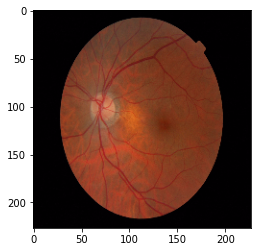

In [5]:
#Read the data and split into train and validation
from sklearn.model_selection import train_test_split
import h5py
f = h5py.File('1194_DR_smallimages.h5', 'r')
images = f['images']
print(images.shape)
labels = np.array(f['meta'])
print(f'Number of images = {len(labels)}')
#Plot the image and its label
num = 100
plt.imshow(images[num])
print(f"This image has DR = {labels[num]}")
print(f"Maximum pixel value in image = {np.max(images[num])}")

# Task 1: Data Pre-processing: 
1. Exploratory data analysis (Frequency of labels)
2. Normalization of images in [0, 1] range.
3. Generation of Training, Test data sets (66/33% split)

### Exercise: Plot a histogram illustrating the number of images corresponding to each DR severity label

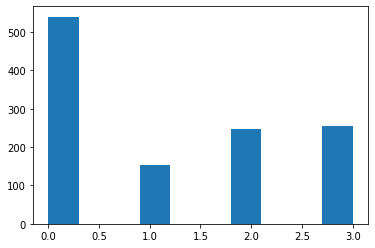

In [40]:
### START CODE HERE ###
plt.hist(labels)
plt.show()
### END CODE HERE ###

### Exercise: Normalize the images' pixel values so they fall in the range [0, 1]

Maximum pixel value in an image = 1.0


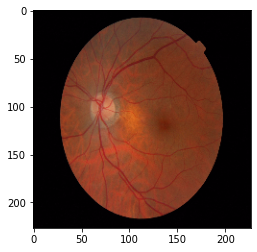

In [17]:
### START CODE HERE ###
images_new = images.value / 255
### END CODE HERE ###
plt.imshow(images_new[100])
print(f"Maximum pixel value in an image = {np.max(images_new[10])}")

### Exercise: Binarize the class labels. Set up 2 one-hot-encoded columns. Column 0 will contain a 1 for every row where the label is 0. Column 1 will contain a 1 for every row where the label is 1, 2, or 3.

### You might be wondering why we don't use a single one-hot-encoded column, since our problem is binary classification. This will become clear in Task 2, when we inspect the AlexNet architecture. 


In [29]:
### START CODE HERE ###
# Initialize the one-hot-encoded array of labels as 2 columns of zeros
one_hot_labels = np.zeros((labels.shape[0], 2))
# Find the rows where the label is 0
lab0 = np.where(labels == 0)[0]
# Find the rows where the label is 1, 2, or 3
lab1 = np.where(labels != 0)[0]
# Set column 0 to 1 in the rows where the label is 0
one_hot_labels[lab0, 0] = 1
# Set column 1 to 1 in the rows where the label is 1, 2, or 3
one_hot_labels[lab1, 1] = 1
print('Number of 0 labels: {0}'.format(sum(one_hot_labels[:, 0])))
print('Number of 1, 2, 3 labels: {0}'.format(sum(one_hot_labels[:, 1])))
### END CODE HERE ###

Number of 0 labels: 540.0
Number of 1, 2, 3 labels: 654.0


### Exercise: Perform a 2/3 - 1/3 train-test split on the data

X_train.shape = (796, 227, 227, 3)
X_test.shape  = (398, 227, 227, 3)
Negative examples in train: 364.0
Negative examples in test: 176.0
Positive examples in train: 432.0
Positive examples in test: 222.0


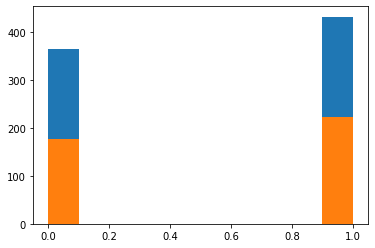

In [36]:
### START CODE HERE ###
def split_data(mat, target, train_ratio):
    # Get the number of rows in the training data
    assert mat.shape[0] == target.shape[0]
    num_train_rows = int(mat.shape[0] * train_ratio)
    shuffled_rows = np.random.permutation(mat.shape[0])
    train_rows = shuffled_rows[:num_train_rows]
    test_rows = shuffled_rows[num_train_rows:]
    # Place the first `train_rows` shuffled rows into the training data 
    # and the remaining rows into the test data
    X_train = mat[train_rows, :]
    X_test  = mat[test_rows, :]
    Y_train = target[train_rows, :]
    Y_test  = target[test_rows, :]
    return X_train, X_test, Y_train, Y_test

# Call the function you just defined to create the training and test data
X_train, X_test, Y_train, Y_test = split_data(images_new, one_hot_labels, 2 / 3)

### END CODE HERE ###
# Visualize the distribution of the binarized labels for both the training and test data
plt.hist(Y_train[:,1])
plt.hist(Y_test[:,1])
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print('Negative examples in train: {0}'.format(np.sum(Y_train[:, 0])))
print('Negative examples in test: {0}'.format(np.sum(Y_test[:, 0])))
print('Positive examples in train: {0}'.format(np.sum(Y_train[:, 1])))
print('Positive examples in test: {0}'.format(np.sum(Y_test[:, 1])))

# Task 2: Model Definition, classification and prediction (No regularization)

## AlexNet architecture

In [34]:
# Define the AlexNet model [This is given]
#1. Model Definition
class AlexNet(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(Flatten())
    
    self.add(Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

### Since our problem involves binary classification, set `num_classes` to 2

In [35]:
num_classes = 2

### Exercise: Instantiate the model and summarize its architecture

In [39]:
### START CODE HERE ###
input_shape = X_train.shape[1:]
print(input_shape)
model = AlexNet(input_shape, num_classes)
model.summary()
### END CODE HERE ###

(227, 227, 3)
Model: "alex_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_10 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_11 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13

### Exercise: Train the model. If you want to use TensorBoard to visualize how its properties evolve over the training epochs, you'll have to create a log directory and employ a TensorBoard callback. If you'd like, you can implement them in v1 of this notebook, but it's not required. v2 will include them, however.
### In training the model, set aside 20% of the data as a validation set. Use a batch size of 100. Set the output verbosity to 1. Train the model for 40 epochs.

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from helper_functions import *

### START CODE HERE ###
log_dir = 'logs_{0}'.format(datetime.now())
tensorboard_callback = TensorBoard(log_dir=log_dir)
training_history = model.fit(
    x=X_train,
    y=Y_train,
    validation_split=0.2,
    batch_size=100,
    epochs=40,
    verbose=1,
    callbacks=[tensorboard_callback]
)
### END CODE HERE ###

print("Average test loss: ", np.average(training_history.history['loss']))

Train on 636 samples, validate on 160 samples
Epoch 1/40
636/636 [==============================] - 38s 60ms/sample - loss: 22.0606 - accuracy: 0.5425 - val_loss: 531477.4336 - val_accuracy: 0.4938
Epoch 2/40
636/636 [==============================] - 35s 56ms/sample - loss: 5.2299 - accuracy: 0.5613 - val_loss: 49457.0474 - val_accuracy: 0.4938
Epoch 3/40
636/636 [==============================] - 36s 56ms/sample - loss: 6.6507 - accuracy: 0.5346 - val_loss: 11537.7605 - val_accuracy: 0.4938
Epoch 4/40
636/636 [==============================] - 34s 53ms/sample - loss: 6.1989 - accuracy: 0.5126 - val_loss: 4146.7412 - val_accuracy: 0.4938
Epoch 5/40
636/636 [==============================] - 34s 54ms/sample - loss: 3.9115 - accuracy: 0.6226 - val_loss: 1836.4979 - val_accuracy: 0.4938
Epoch 6/40
636/636 [==============================] - 34s 53ms/sample - loss: 3.9074 - accuracy: 0.5865 - val_loss: 912.5553 - val_accuracy: 0.4938
Epoch 7/40
636/636 [==============================] - 35

### Exercise: Display loss and accuracy for both the training and validation data. You should find the provided functions in `helper_functions.py` useful. 

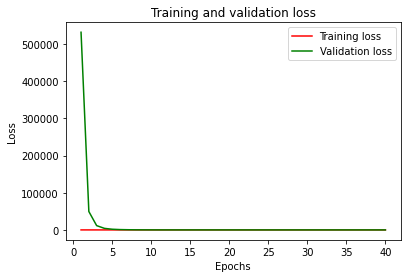

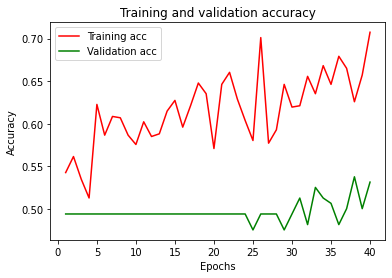

In [42]:
### START CODE HERE ###
print_loss_history(training_history)
print_accuracy_history(training_history)
### END CODE HERE ###

### Exercise: Generate predictions with the test data

In [43]:
### START CODE HERE ###
prediction_values = model.predict(X_test)
### END CODE HERE ###

In [57]:
print(prediction_values.shape)
print(prediction_values[:10])
print(np.argmax(prediction_values, axis=1))
print(Y_test.shape)
print(Y_test[:10])
print(np.argmax(Y_test, axis=1))
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(prediction_values, axis=1)

(398, 2)
[[0.00597568 0.99402434]
 [0.00191998 0.99808   ]
 [0.01377471 0.98622525]
 [0.01749601 0.98250395]
 [0.0013463  0.99865365]
 [0.01350075 0.9864993 ]
 [0.011822   0.98817796]
 [0.01419635 0.9858036 ]
 [0.1186727  0.88132733]
 [0.0024636  0.9975364 ]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

### Exercise: Evaluate the predictions against the Number 1 column of `Y_test`

In [58]:
### START CODE HERE ###
# Import the necessary functions from sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print(f'Accuracy = {accuracy_score(y_true, y_pred)}')
print(f'F1 = {f1_score(y_true, y_pred)}')
print(f'Precision = {precision_score(y_true, y_pred)}')
print(f'Recall = {recall_score(y_true, y_pred)}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(y_true, y_pred)
### END CODE HERE ###

Accuracy = 0.5402010050251256
F1 = 0.6893039049235993
Precision = 0.553133514986376
Recall = 0.9144144144144144
Confusion matrix =


array([[ 12, 164],
       [ 19, 203]])

### Next, visualize the activations.
Source: https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

### Exercise: Extract the activations for each layer in our AlexNet model

In [59]:
### START CODE HERE ###
# Use a list comprehension to extract the output of each layer in the model
layer_outputs = [layer.output for layer in model.layers]
# Define a new model with the same input shape as the original model 
# and layer_outputs as its outputs
activation_model = Model(inputs=model.input, outputs=layer_outputs)
# Get all the activations by calling the predict() method on the number 10 image 
# in X_train. Make sure to reshape the image so it has a new 0 axis of length 1.
activations = activation_model.predict(np.expand_dims(X_train[10], axis=0))
### END CODE HERE ###

### Exercise: Display the first 64 activations of the second model layer (layer index 1) in an 8 x 8 grid. Again, the helper functions are your friends.

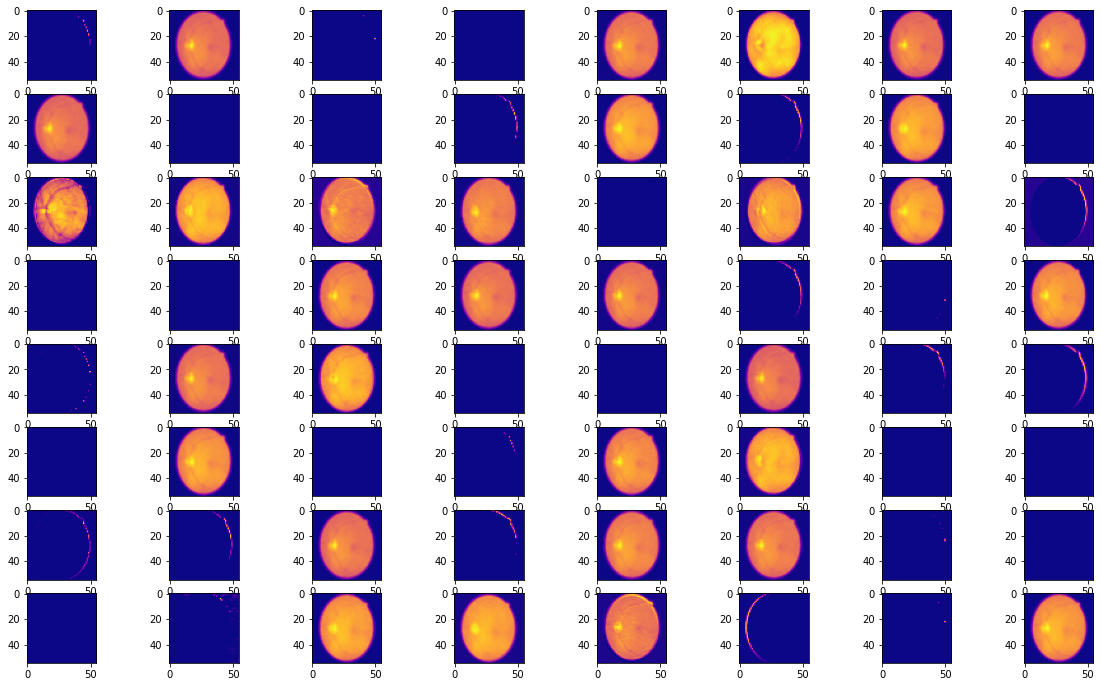

In [60]:
### START CODE HERE ###
display_activation(activations, 8, 8, 1)
### END CODE HERE ###

### Exercise: Display the first 64 activations of the 11th model layer (layer index 10) in an 8 x 8 grid

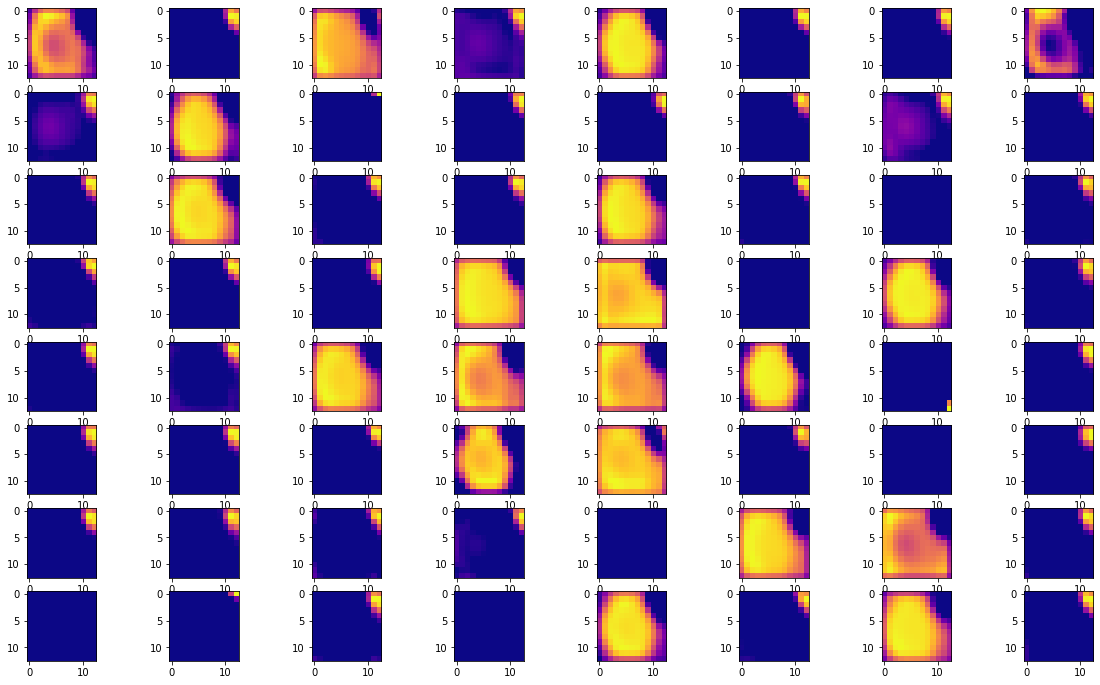

In [61]:
### START CODE HERE ###
display_activation(activations, 8, 8, 10)
### END CODE HERE ###

# Comment on the activated feature maps for early layers to later layers. What pattern do you observe?

# Task 3: Regularization by Data Augmentation [Instructor Led]

## We can regularize our model (and, in doing so, hopefully improve it) by augmenting our image data. Image augmentation includes transformations such as rotation, translation, reflection, shearing, and color permutation. TensorFlow provides the ImageDataGenerator class to perform image augmentation in memory; by default, your local storage won't save the newly generated images.

In [62]:
# Create a Data Generator
data_gen_args = dict( 
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)
image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)
BATCH_SIZE = X_train.shape[0]

### Initialize data generator for training/validation and test data sets

In [63]:
train_generator = image_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
test_generator = image_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE)

### Import libraries and set useful parameters

In [64]:
import h5py
from tensorflow.keras.utils import HDF5Matrix
seed = 0
aug_batch_size = 6

## Step 1: Understanding the data augmentation process
Images are randomly generated with the options provided in the image data generator

Epoch 0
(6, 227, 227, 3)


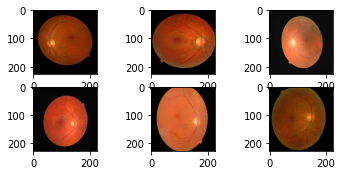

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Epoch 1
(6, 227, 227, 3)


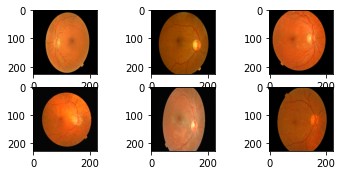

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Epoch 2
(6, 227, 227, 3)


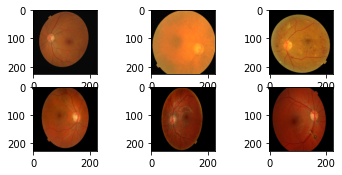

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Epoch 3
(6, 227, 227, 3)


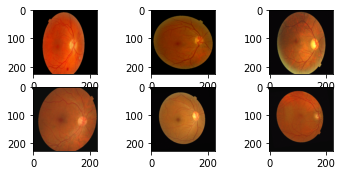

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Epoch 4
(6, 227, 227, 3)


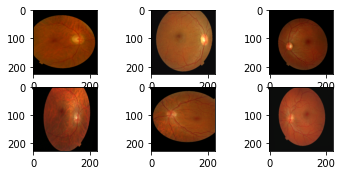

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [65]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in image_datagen.flow(X_train, Y_train, batch_size=aug_batch_size):
        print(x_batch.shape)
        for i in range(0, aug_batch_size):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        

        plt.show()
        print(y_batch)
        break

## Step 2: Using augmented data to Train the model
### Visualize using tensorboard

### Method 1: Iterate through randomized `(X, y)` batches generated by `train_generator` and fit AlexNet to each one

In [66]:
model_reg = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)

In [67]:
#Method 1: Randomized batches
EPOCHS = 50
reg_history_loss = []
reg_history_vloss = []
reg_history_accuracy = []
reg_history_val_accuracy = []
# Start training
for e in range(EPOCHS):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in train_generator:
        reg_hist = (model_reg.fit(x_batch, y_batch,validation_split=0.2, verbose=1))
        batches += 1
        reg_history_loss.append(reg_hist.history['loss'])
        reg_history_vloss.append(reg_hist.history['val_loss'])
        reg_history_accuracy.append(reg_hist.history['accuracy'])
        reg_history_val_accuracy.append(reg_hist.history['val_accuracy'])
        if batches >= len(X_train) / BATCH_SIZE:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break  




Epoch 0
Train on 636 samples, validate on 160 samples
636/636 [==============================] - 40s 63ms/sample - loss: 15.3351 - accuracy: 0.5126 - val_loss: 1426.3828 - val_accuracy: 0.5500
Epoch 1
Train on 636 samples, validate on 160 samples
636/636 [==============================] - 37s 59ms/sample - loss: 5.8139 - accuracy: 0.5252 - val_loss: 45.4316 - val_accuracy: 0.6313
Epoch 2
Train on 636 samples, validate on 160 samples
636/636 [==============================] - 38s 59ms/sample - loss: 4.7061 - accuracy: 0.5047 - val_loss: 28.2876 - val_accuracy: 0.5562
Epoch 3
Train on 636 samples, validate on 160 samples
636/636 [==============================] - 38s 59ms/sample - loss: 3.0158 - accuracy: 0.5142 - val_loss: 13.7264 - val_accuracy: 0.5562
Epoch 4
Train on 636 samples, validate on 160 samples
636/636 [==============================] - 39s 62ms/sample - loss: 2.3842 - accuracy: 0.5755 - val_loss: 4.1023 - val_accuracy: 0.5250
Epoch 5
Train on 636 samples, validate on 160 sa

KeyboardInterrupt: 

### Plot the losses and accuracies for both training and validation data

In [68]:
#Print the loss and accuracies
#print_loss_history(reg_history)
t_loss = np.squeeze(np.array(reg_history_loss))
v_loss = np.squeeze(np.array(reg_history_vloss))
t_acc  = np.squeeze(np.array(reg_history_accuracy))
v_acc  = np.squeeze(np.array(reg_history_val_accuracy))
print(len(t_loss))

19


### Loss

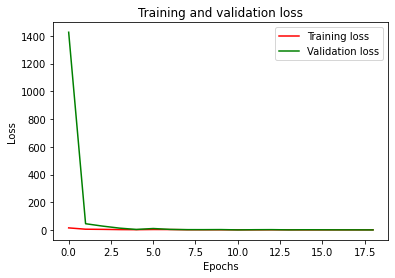

In [69]:
epochs = range(len(t_loss))
plt.plot(epochs, t_loss, color='red', label='Training loss')
plt.plot(epochs, v_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

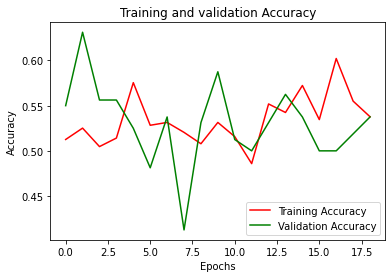

In [70]:
epochs=range(len(t_acc))
plt.plot(epochs, t_acc, color='red', label='Training Accuracy')
plt.plot(epochs, v_acc, color='green', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Method 2: Pass `train_generator` into the model's `fit()` method directly and abstract away the looping

In [ ]:
#Method 2
model_reg_2 = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)
reg_history = model_reg_2.fit(
    train_generator,
    steps_per_epoch=50,
    verbose=1, 
    epochs=40,
#    callbacks=[tensorboard_callback]
)

print("Average test loss: ", np.average(reg_history.history['loss']))

In [ ]:
# save the whole model
model_reg_2_dir = "reg_model.h5"
model_reg_2.save(model_reg_2_dir)

In [ ]:
%tensorboard --logdir logs/scalars

# Task 4: Evaluate the Regularized Model and Report Results

### Exercise: Compute the evaluation metrics

In [ ]:
### START CODE HERE ###
prediction_reg = None
print(f'Accuracy = {None}')
print(f'F1 = {None}')
print(f'Precision = {None}')
print(f'Recall = {None}')
print('Confusion matrix = ')
None
### END CODE HERE ###

# Visualize activations from early layers after regularization and report results